# Image Classification with Keras

## Setup

### Libraries
- http://www.numpy.org/
- https://keras.io/
- https://www.tensorflow.org/

In [1]:
from pathlib import Path
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


### Configuration

In [2]:
NBR_EPOCHS = 30
RUN_NAME = "run-1-{}-epochs".format(NBR_EPOCHS)
LOGDIR = './output/logs/{}'.format(RUN_NAME)

### Constants

In [3]:
# These are the CIFAR10 class labels from the training data (in order from 0 to 9)
cifar10_class_names = [
    "Plane",
    "Car",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Boat",
    "Truck"
]

## Load data
- https://en.wikipedia.org/wiki/CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

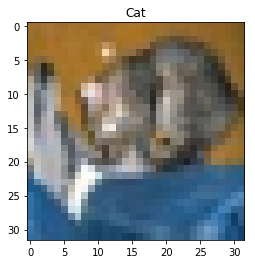

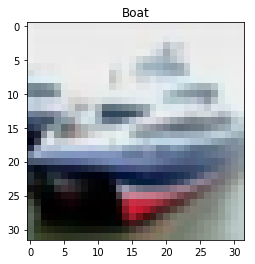

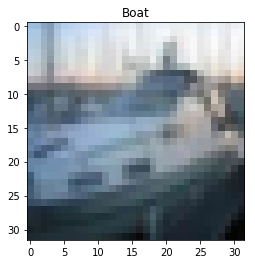

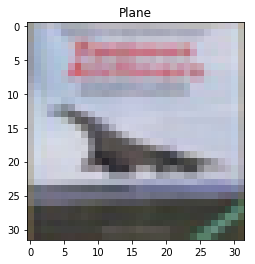

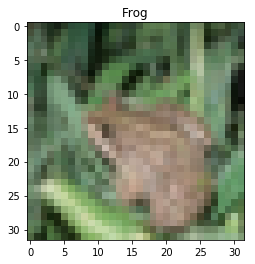

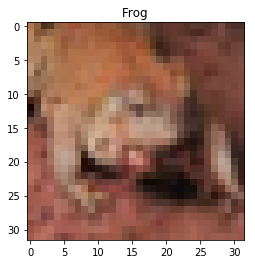

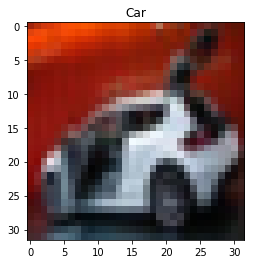

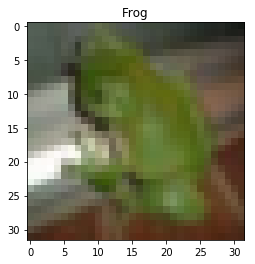

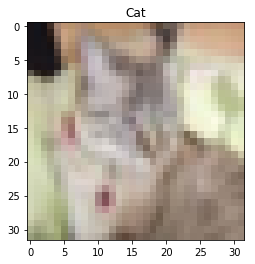

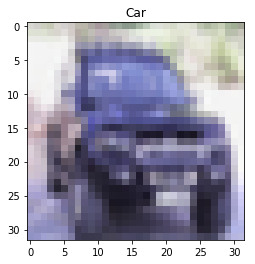

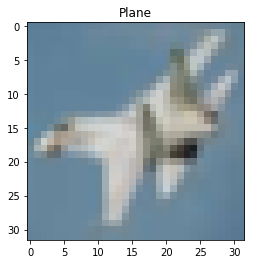

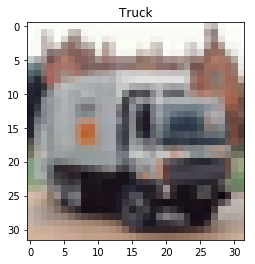

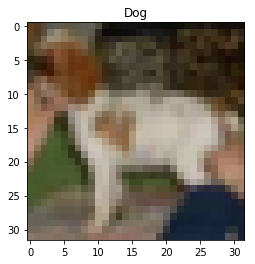

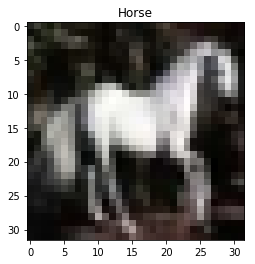

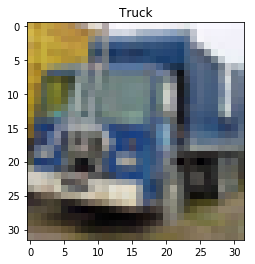

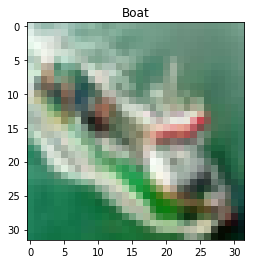

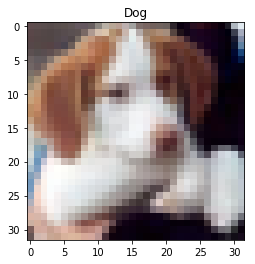

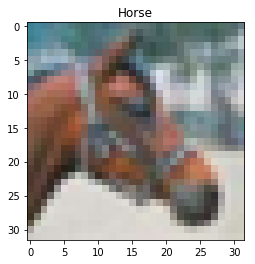

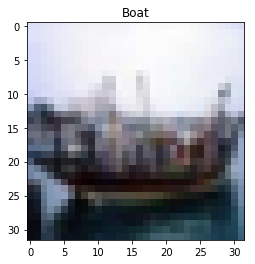

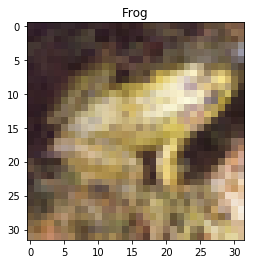

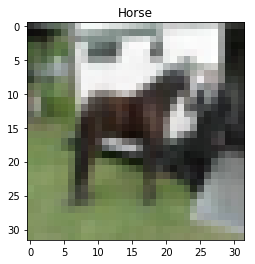

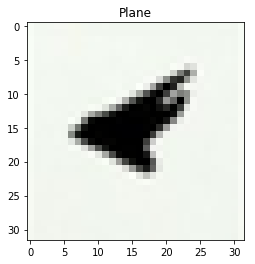

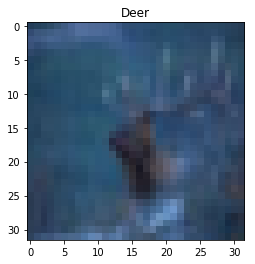

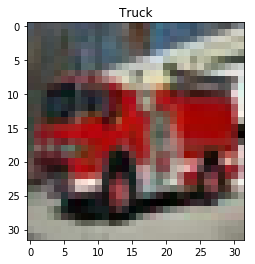

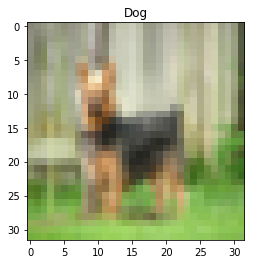

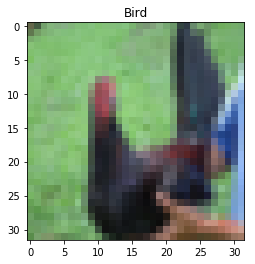

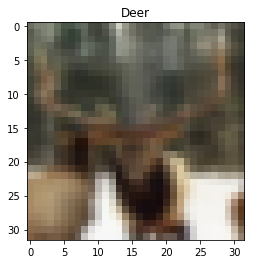

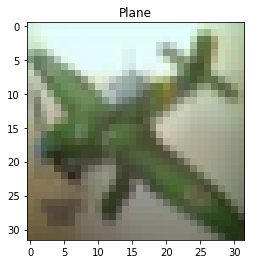

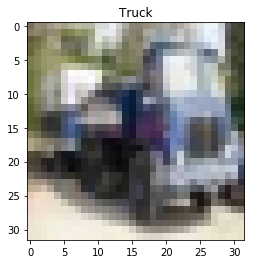

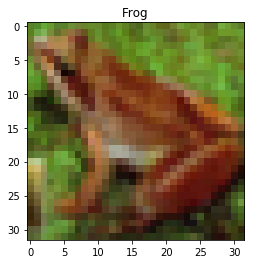

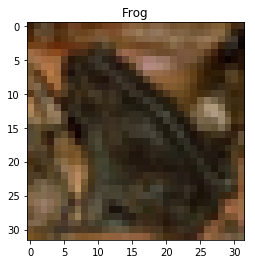

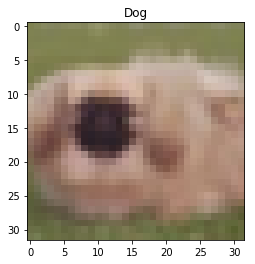

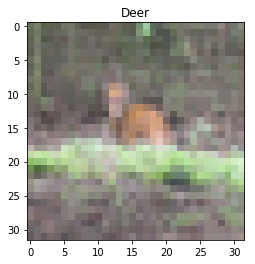

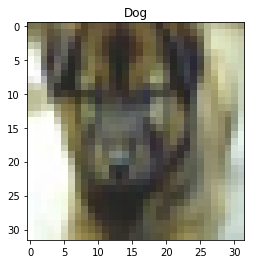

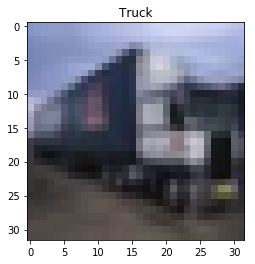

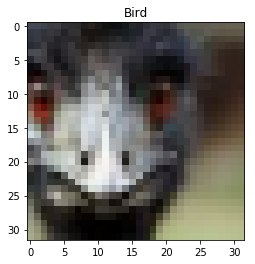

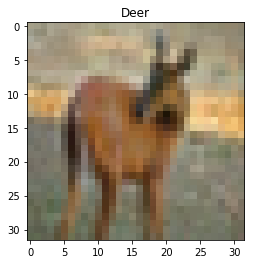

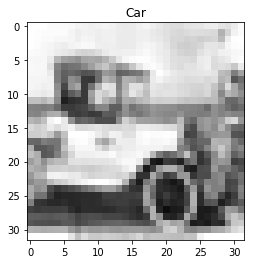

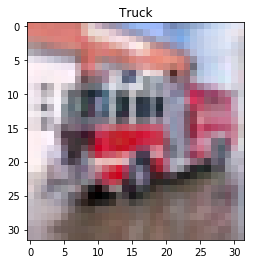

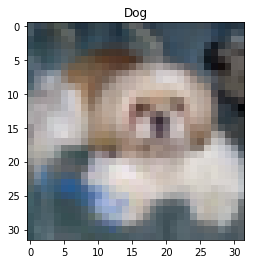

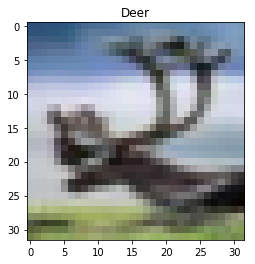

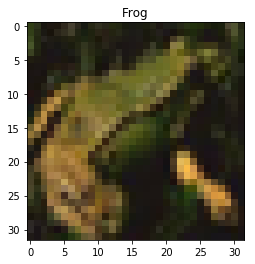

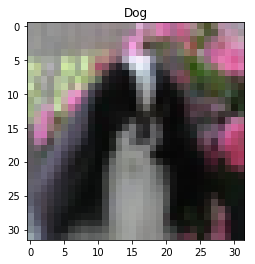

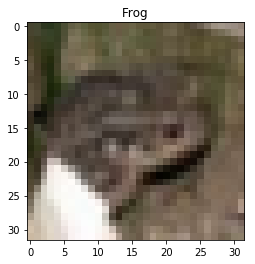

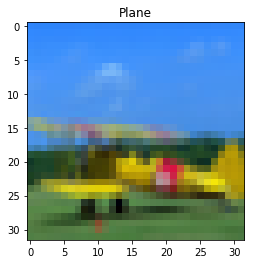

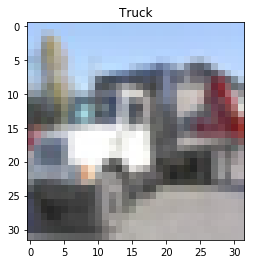

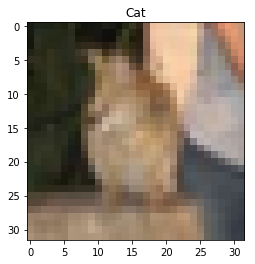

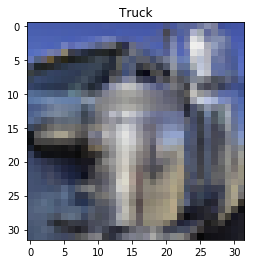

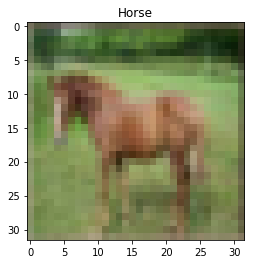

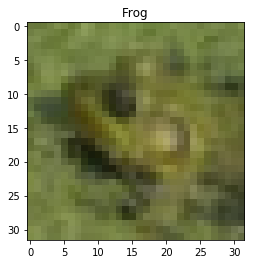

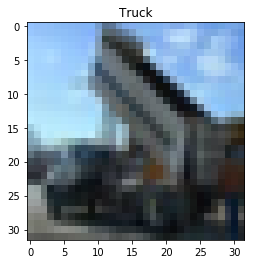

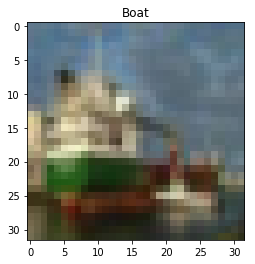

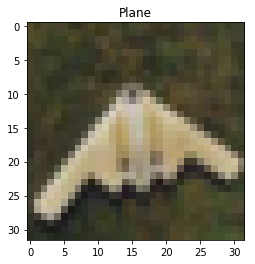

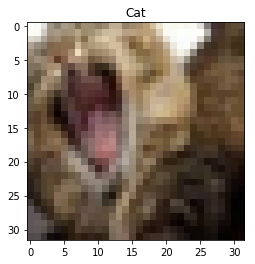

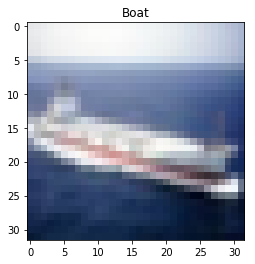

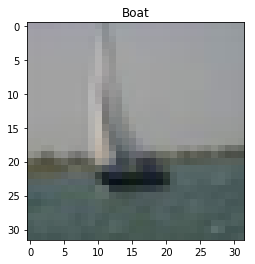

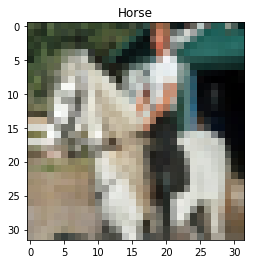

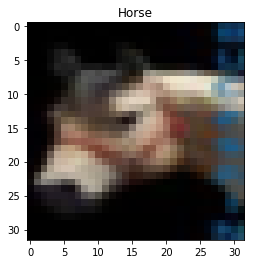

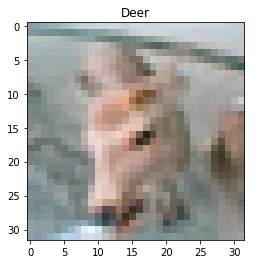

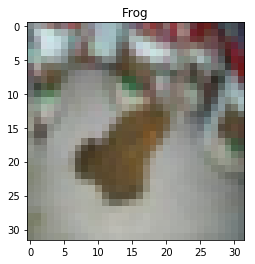

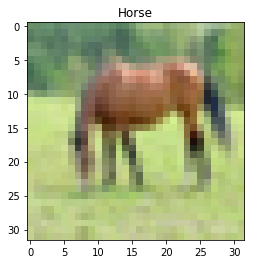

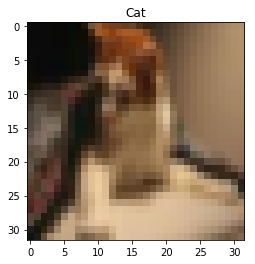

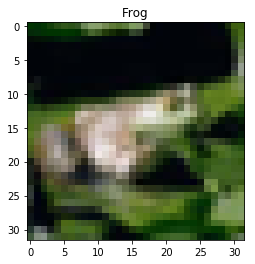

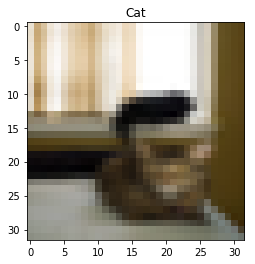

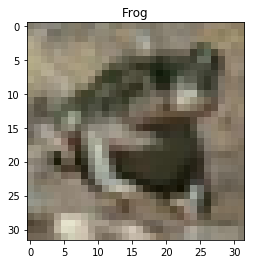

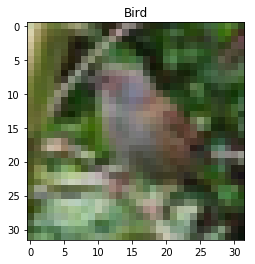

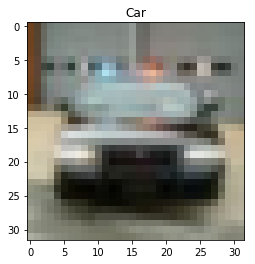

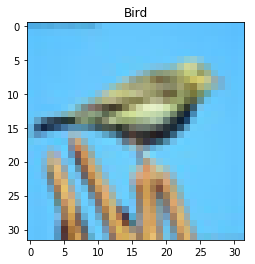

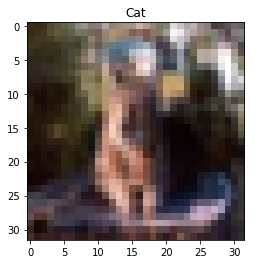

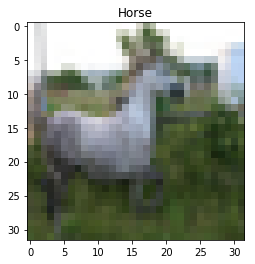

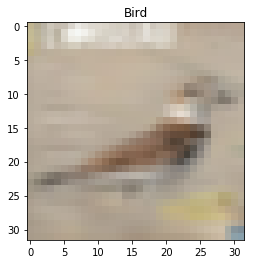

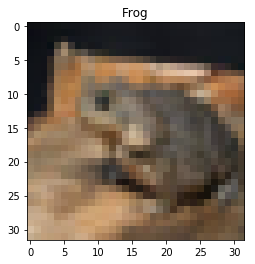

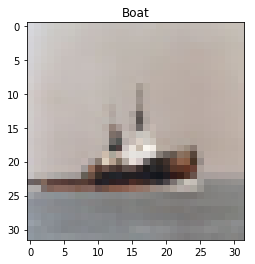

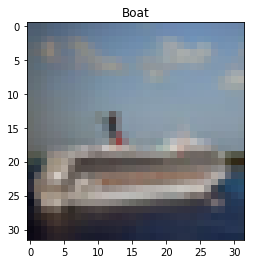

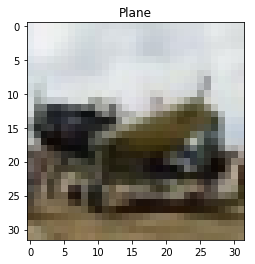

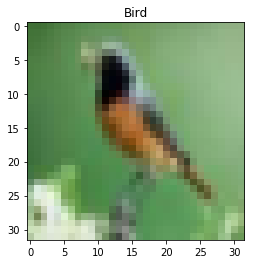

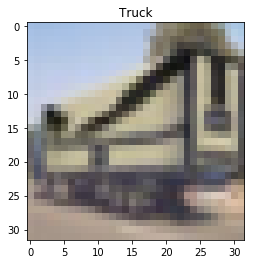

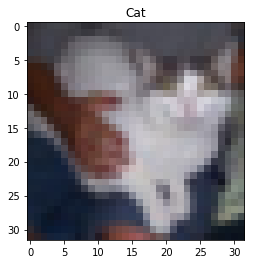

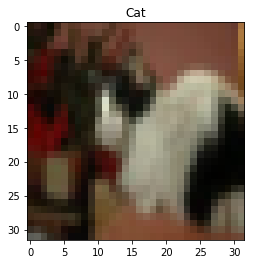

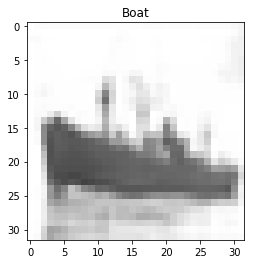

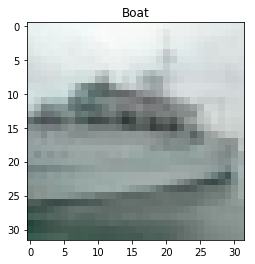

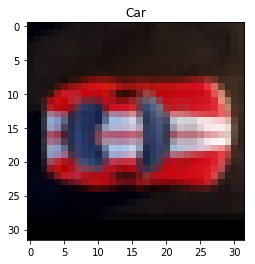

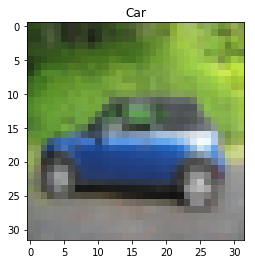

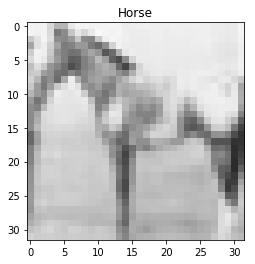

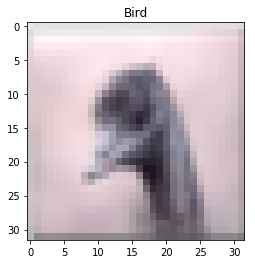

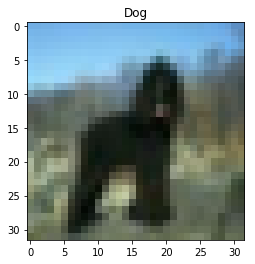

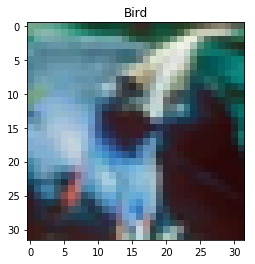

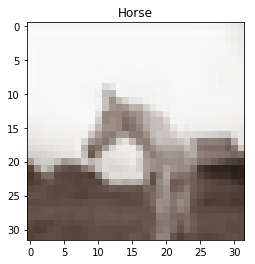

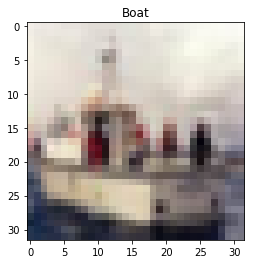

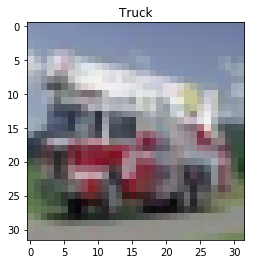

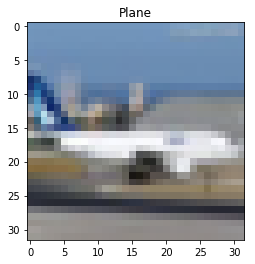

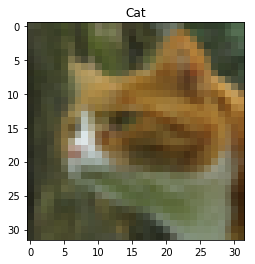

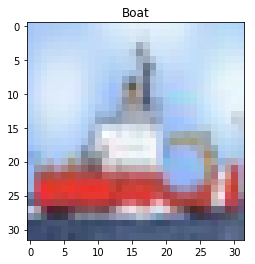

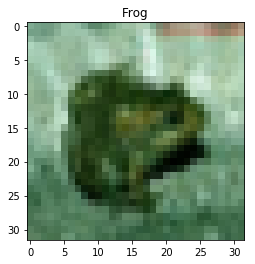

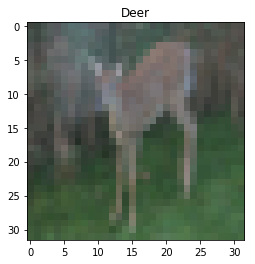

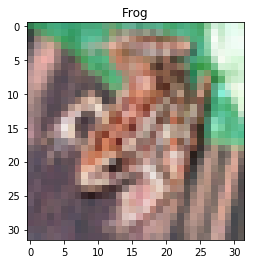

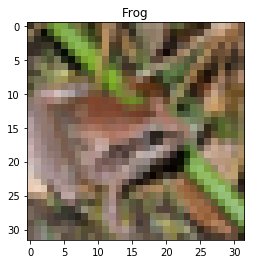

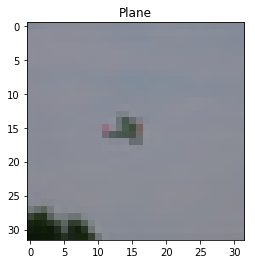

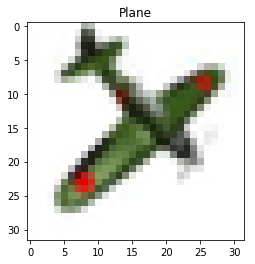

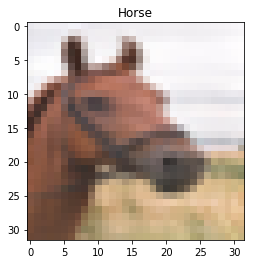

In [23]:
# sample image

# Loop through each picture in the data set
for i in range(100):
    # Grab an image from the data set
    sample_image = x_test[i]
    # Grab the image's expected class id
    image_class_number = int(y_test[i][0])
    
    # Look up the class name from the class id
    image_class_name = cifar10_class_names[image_class_number]

    # Draw the image as a plot
    plt.imshow(sample_image)
    # Label the image
    plt.title(image_class_name)
    # Show the plot on the screen
    plt.show()

In [ ]:
# Normalize data set to 0-to-1 range
x_norm_train = x_train.astype('float32')
x_norm_test = x_test.astype('float32')
x_norm_train /= 255
x_norm_test /= 255

# Convert class vectors to binary class matrices
y_norm_train = keras.utils.to_categorical(y_train, 10)
y_norm_test = keras.utils.to_categorical(y_test, 10)

## Build model

In [ ]:
# Build a model and add layers
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Delete the folder directory
if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)

# Create a TensorBoard logger
logger = keras.callbacks.TensorBoard(
    log_dir=LOGDIR,
    histogram_freq=5,
    write_graph=True
)

# Train the model

In [ ]:
model.fit(
    x_norm_train,
    y_norm_train,
    batch_size=64,
    epochs=NBR_EPOCHS,
    callbacks=[logger],
    validation_data=(x_norm_test, y_norm_test),
    shuffle=True
)

## Save the model

In [ ]:
# Save neural network structure
model_structure = model.to_json()
f = Path("models/keras_trained_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save("models/keras_trained_model.h5")

In [ ]:
# Export model as Tensorflow model

sess = K.get_session()

classify_model = load_model('models/keras_trained_model.h5')

# Delete the existing folder (if there)
model_path = Path('models/keras_exported_model')
if os.path.exists(model_path):
    shutil.rmtree(model_path)
    
inputs = {
    'input': tf.saved_model.utils.build_tensor_info(classify_model.input)
}
outputs = {
    'scores': tf.saved_model.utils.build_tensor_info(classify_model.output)
}

signature_def = tf.saved_model.signature_def_utils.build_signature_def(
    inputs=inputs,
    outputs=outputs,
    method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME
)

model_builder = tf.saved_model.builder.SavedModelBuilder("models/keras_exported_model")

model_builder.add_meta_graph_and_variables(
    sess=sess,
    tags=[tf.saved_model.tag_constants.SERVING],
    signature_def_map={ tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature_def}
)

model_builder.save()

## Predict

In [4]:
# Recreate the Keras model object from the json data
prediction_model = load_model('models/keras_trained_model.h5')

This is image is a Car - Likelihood: 0.768830


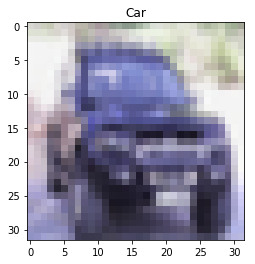

In [10]:
# Predict

# Load an image file to test, resizing it to 32x32 pixels (as required by this model)
img = image.load_img("data/images/truck.png", target_size=(32, 32))

# Convert the image to a numpy array
image_to_test = image.img_to_array(img)

# Normalize data set to 0-to-1 range
x_norm_image = image_to_test.astype('float32') / 255

# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
list_of_images = np.expand_dims(x_norm_image, axis=0)

# Make a prediction using the model
results = prediction_model.predict(list_of_images)

# Since we are only testing one image, we only need to check the first result
single_result = results[0]

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
most_likely_class_index = int(np.argmax(single_result))
class_likelihood = single_result[most_likely_class_index]

# Get the name of the most likely class
class_label = cifar10_class_names[most_likely_class_index]

# Print the result
print("This is image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))

# Draw the image as a plot
plt.imshow(img)
# Label the image
plt.title(class_label)
# Show the plot on the screen
plt.show()

## Troubleshooting

In [ ]:
# Check the model signature with saved_model_cli

!saved_model_cli show --dir ./models/keras_exported_model  --all

In [ ]:
# Visualize the log

# Note: Stop once done
!tensorboard --logdir=$LOGDIR

TensorBoard 1.11.0 at http://Jerome-Curliers-MacBook-Pro.local:6006 (Press CTRL+C to quit)
